In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("Manhattan12.csv", skiprows=4)
df.shape

(27395, 21)

In [3]:
df.columns = df.columns.str.replace("\n", "").str.replace(" ", "_")
df.rename(columns={"SALEPRICE": "SALE_PRICE", "APARTMENTNUMBER": "APARTMENT_NUMBER"}, inplace=True)

In [4]:
df.columns = df.columns.str.strip().str.replace("\n", "")

def format_and_convert_column_to_numeric(col, dtype):
    df[col] = df[col].str.replace(",","").str.replace("$","").astype(dtype)
    
format_and_convert_column_to_numeric('SALE_PRICE', np.int64)
format_and_convert_column_to_numeric('GROSS_SQUARE_FEET', np.float64)
format_and_convert_column_to_numeric('LAND_SQUARE_FEET', np.float64)
format_and_convert_column_to_numeric('RESIDENTIAL_UNITS', np.int64)
format_and_convert_column_to_numeric('TOTAL_UNITS', np.int64)

# Convert To datetime
df['SALE_DATE'] =pd.to_datetime(df['SALE_DATE'], dayfirst=True)

df['YEAR_BUILT'] = df['YEAR_BUILT'].astype(np.int64)

/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_82534/1126458197.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace(",","").str.replace("$","").astype(dtype)


In [5]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
print("Categorical columns: ", categorical)
print("Numerical columns: ", numerical)

Categorical columns:  ['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'BUILDING_CLASS_AT_TIME_OF_SALE']
Numerical columns:  ['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE']


In [6]:
df[categorical] = df[categorical].applymap(lambda x: x.replace(r" +", ""))
df[categorical] = df[categorical].applymap(lambda x: " ".join(x.split()))

In [7]:
df[categorical] = df[categorical].replace("", np.nan)
df[numerical] = df[numerical].replace(0, np.nan)

In [8]:
df.isna().sum() / df.shape[0] * 100

BOROUGH                             0.000000
NEIGHBORHOOD                        0.062055
BUILDING_CLASS_CATEGORY            12.608140
TAX_CLASS_AT_PRESENT                0.521993
BLOCK                               0.000000
LOT                                 0.000000
EASE-MENT                         100.000000
BUILDING_CLASS_AT_PRESENT           0.521993
ADDRESS                             0.000000
APARTMENT_NUMBER                   53.184888
ZIP_CODE                            0.003650
RESIDENTIAL_UNITS                  59.762730
COMMERCIAL_UNITS                   87.468516
TOTAL_UNITS                        35.422522
LAND_SQUARE_FEET                   83.613798
GROSS_SQUARE_FEET                  84.208797
YEAR_BUILT                         23.511590
TAX_CLASS_AT_TIME_OF_SALE           0.000000
BUILDING_CLASS_AT_TIME_OF_SALE      0.000000
SALE_PRICE                         27.716737
SALE_DATE                           0.000000
dtype: float64

In [9]:
df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
df.columns

Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [10]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.isna().sum()

NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

<AxesSubplot: >

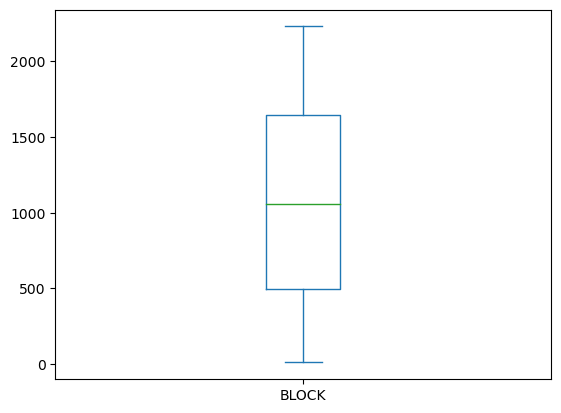

In [11]:
df['BLOCK'].plot.box()

<AxesSubplot: >

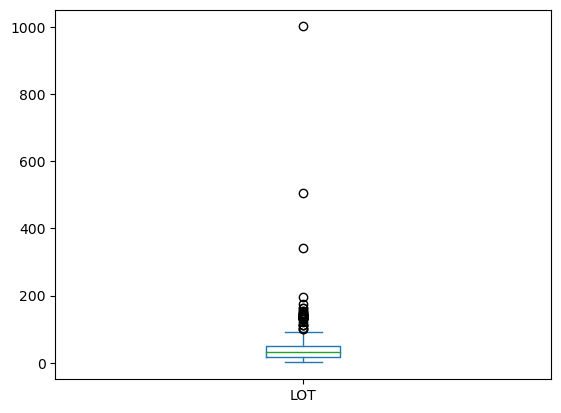

In [12]:
df[['LOT']].plot.box()

<AxesSubplot: >

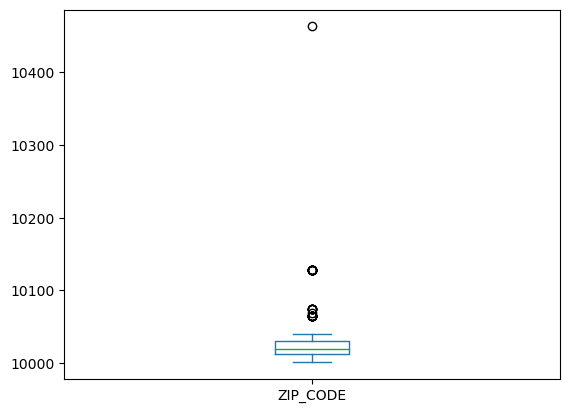

In [13]:
df['ZIP_CODE'].plot.box()

<AxesSubplot: >

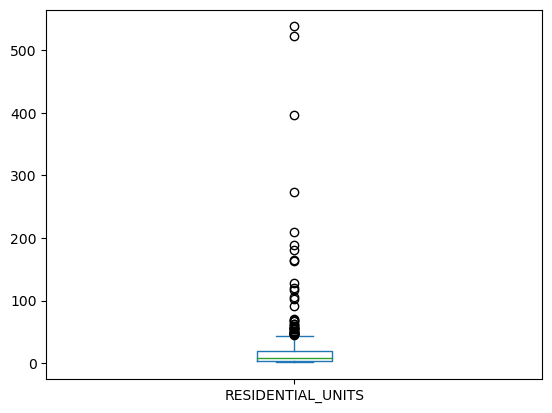

In [14]:
df['RESIDENTIAL_UNITS'].plot.box()

<AxesSubplot: >

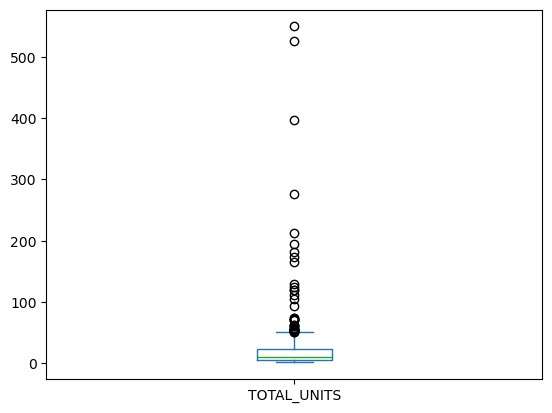

In [15]:
df['TOTAL_UNITS'].plot.box()

In [16]:
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
z_scores = np.abs(stats.zscore(df[numerical]))

In [17]:
new_df = df[(z_scores<3).all(axis=1)]

In [18]:
new_df.shape

(428, 18)

In [19]:
new_df.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,4.280000e+02
mean,1086.976636,39.278037,10020.780374,14.130841,1.946262,16.046729,3408.228972,14984.147196,1911.738318,2.172897,7.237444e+06
std,633.933388,32.886146,14.672806,16.554974,1.477199,17.300557,2936.258133,17234.925082,11.045646,0.763950,8.083480e+06
min,11.000000,1.000000,10001.000000,1.000000,1.000000,1.000000,469.000000,1875.000000,1877.000000,1.000000,1.000000e+01
25%,485.000000,17.750000,10011.000000,3.000000,1.000000,5.000000,1824.250000,5606.000000,1900.000000,2.000000,3.037500e+06
50%,1033.500000,31.500000,10019.000000,8.000000,1.000000,9.000000,2422.000000,8693.500000,1910.000000,2.000000,5.141960e+06
75%,1648.750000,49.250000,10029.000000,19.000000,2.000000,21.000000,3758.750000,15471.000000,1920.000000,2.000000,8.356967e+06
max,2230.000000,175.000000,10075.000000,120.000000,10.000000,125.000000,15987.000000,111457.000000,1967.000000,4.000000,7.600000e+07


In [20]:

new_df['SALE_PRICE'] = np.log(df['SALE_PRICE'])


/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_82534/1768186329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['SALE_PRICE'] = np.log(df['SALE_PRICE'])


<AxesSubplot: ylabel='Frequency'>

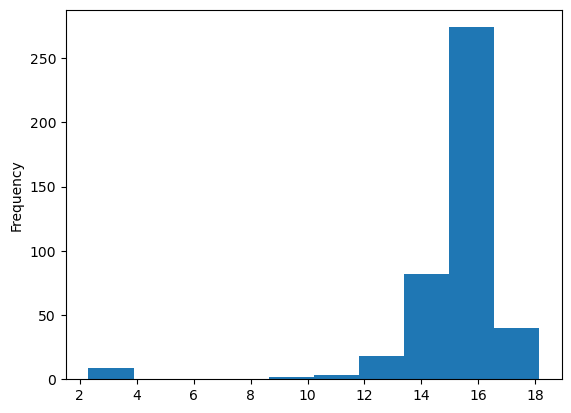

In [21]:
new_df['SALE_PRICE'].plot.hist()

In [22]:
numerical.remove("SALE_PRICE")
new_df[numerical] = (new_df[numerical] - new_df[numerical].min()) / (new_df[numerical].max() - new_df[numerical].min())

/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_82534/1297390553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[numerical] = (new_df[numerical] - new_df[numerical].min()) / (new_df[numerical].max() - new_df[numerical].min())


In [23]:
new_df.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.484893,0.219989,0.267302,0.110343,0.105140,0.121345,0.189408,0.119629,0.385981,0.390966,15.097228
std,0.285684,0.189001,0.198281,0.139117,0.164133,0.139521,0.189216,0.157279,0.122729,0.254650,2.150681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.302585
25%,0.213610,0.096264,0.135135,0.016807,0.000000,0.032258,0.087334,0.034048,0.255556,0.333333,14.926520
50%,0.460793,0.175287,0.243243,0.058824,0.000000,0.064516,0.125854,0.062223,0.366667,0.333333,15.452944
75%,0.738058,0.277299,0.378378,0.151261,0.111111,0.161290,0.211996,0.124071,0.477778,0.333333,15.938602
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.146244


In [24]:
new_df.shape

(428, 18)